In [168]:
import os
from dotenv import load_dotenv
import sqlalchemy
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_period_transactions
import seaborn as sns

In [169]:
# load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

In [170]:
# Create database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [171]:
# function to create df
def create_df(table_name):
    try:
        connection = engine.connect() 
        query = f'''
        SELECT 
            *
        FROM
            {table_name} 
        '''
        
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback() 
    finally:
        connection.close()  

def create_full_table():
    full_table = create_df('online_sales')
    tables = {'products': 'product_id',
              'users': 'user_id',
              'ratings': 'product_id'
              }
    for key, value in tables.items():
        df = create_df(key)
        full_table = pd.merge(full_table, df, on=value, how='inner')

    full_table['total_price'] = np.where(
    full_table['Coupon_Status'] == 'Used',
    full_table['Quantity'] * full_table['actual_price'] * (1 - full_table['Discount_pct']),
    full_table['Quantity'] * full_table['actual_price']
    )

    return full_table

### CLTV Prediction 
CLTV =BG/NBD Model * Gamma Gamma Submodel


### BG-NBD Model (Beta Geometric/Negative Binomial Distribution)

To predict customer lifetime value (CLTV) metrics, specifically the expected purchases for individual customers and the overall expected transactions for the company in the next month.  

The BG/NDB Model probabilistically models two processes for the Expected Number of Transactions:

Transaction Process (Buy) + Dropout Process (Till you die)  

As long as the Transaction Process is active, a poisson distribution is used to determine how many transactions a client will complete in a given amount of time. As long as a client is alive, it will continue to randomly scatter around its transaction rate.

In [172]:
def bg_nbd():
    today_date = dt.datetime(2020, 1, 1)
    sales = create_full_table()

    cltv_prediction = sales.groupby('user_id').agg({
        'date': [min, max],
        'transaction_id': 'nunique', 
        'total_price': 'sum',
    })

    cltv_prediction.columns = ['earliest_date', 'latest_date', 'frequency', 'monetary']

    cltv_prediction['recency'] = (cltv_prediction['latest_date'] - cltv_prediction['earliest_date']).dt.days
    cltv_prediction["monetary"] = cltv_prediction["monetary"] / cltv_prediction["frequency"]
    cltv_prediction['T'] = (today_date - cltv_prediction['earliest_date']).dt.days

    # he BG/NBD model assumes that customers have already made some repeat purchases to establish a purchasing pattern. 
    # When frequency is 0, there isn’t enough data for the model to make reliable predictions about future transactions hence, remove frequency = 0
    cltv_prediction = cltv_prediction[(cltv_prediction["frequency"] > 1)]
    # some users have multiple transactions on only one day
    cltv_prediction = cltv_prediction[(cltv_prediction["recency"] > 0)]

    cltv_prediction["T"] = cltv_prediction["T"] / 7
    cltv_prediction["recency"] = cltv_prediction["recency"] / 7

    cltv_prediction = cltv_prediction.drop(columns=['earliest_date', 'latest_date'])

    return cltv_prediction

cltv_prediction = bg_nbd()
print(cltv_prediction.head())

         frequency     monetary    recency          T
user_id                                              
12347           31   434.135516  31.857143  40.428571
12348            8  3677.904625  17.000000  27.571429
12370           44  3091.433205   4.285714  31.428571
12377           37  3475.751216  19.857143  25.714286
12383           39   333.387641  10.285714  24.571429


In [173]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"])
cltv_prediction[["frequency", "recency", "T"]].describe()

,frequency,recency,T
count,734.000000,734.000000,734.000000
mean,27.444142,18.388283,34.789607
std,31.499869,14.766543,13.081589
min,2.000000,0.142857,0.285714
25%,10.250000,4.000000,26.857143
50%,19.000000,17.285714,38.000000
75%,34.000000,29.428571,45.821429
max,328.000000,51.142857,52.142857


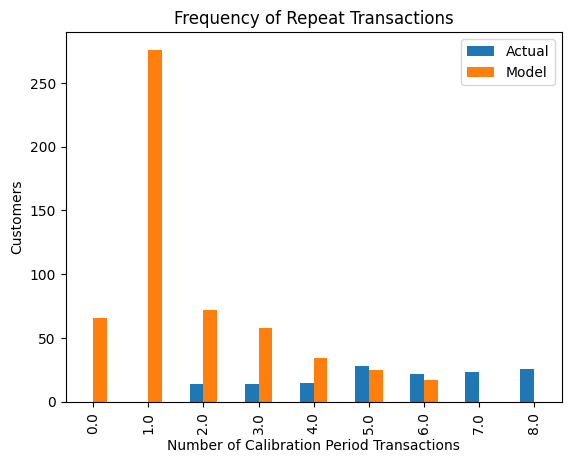

In [174]:
plot_period_transactions(bgf)
plt.show()

We see very high predictions for low frequencies especially for those with only 1 repeat transaction, overestimating the number of customers who fall into these categories. However, for transaction counts of 3 and higher, the actual predicted values appear closed, though there are still some differences at frequencies of 7-8. Hence, we have to keep in mind that the model may not be entirely accurate for customers with infrequent purchases. This could lead to biased CLTV estimates for these customer segments.

In [175]:
# Define number of bootstrap samples
n_bootstrap_samples = 100
bootstrap_results = []

for i in range(n_bootstrap_samples):
    # Sample with replacement
    bootstrap_sample = cltv_prediction.sample(frac=1, replace=True)
    
    # Fit model on bootstrap sample
    bgf.fit(bootstrap_sample["frequency"], bootstrap_sample["recency"], bootstrap_sample["T"])
    
    # Calculate expected transactions for a month
    monthly_pred = bgf.predict(4, bootstrap_sample["frequency"], bootstrap_sample["recency"], bootstrap_sample["T"]).sum()
    bootstrap_results.append(monthly_pred)

# Calculate mean and standard deviation of the bootstrap predictions
bootstrap_mean = np.mean(bootstrap_results)
bootstrap_std = np.std(bootstrap_results)

print(f"Bootstrap Mean Monthly Prediction: {bootstrap_mean}")
print(f"Bootstrap Standard Deviation: {bootstrap_std}")


Bootstrap Mean Monthly Prediction: 389.7538299146121
Bootstrap Standard Deviation: 46.35079857998362


The Bootstrap Mean Monthly Prediction of approximately 423.6 suggests that the model expects around 424 transactions per month across your customer base. The Standard Deviation of about 48.42 indicates some variability in these monthly predictions, but the range (about ±53 transactions) shows a relatively consistent estimate.

top 10 customers and their expected number of purchase in the following week: user_id
16745    6.022207
14606    5.716495
14438    4.794554
15808    2.705972
17315    1.771456
13488    1.527288
14462    1.501528
13050    1.452395
13069    1.439590
12567    1.399107
dtype: float64


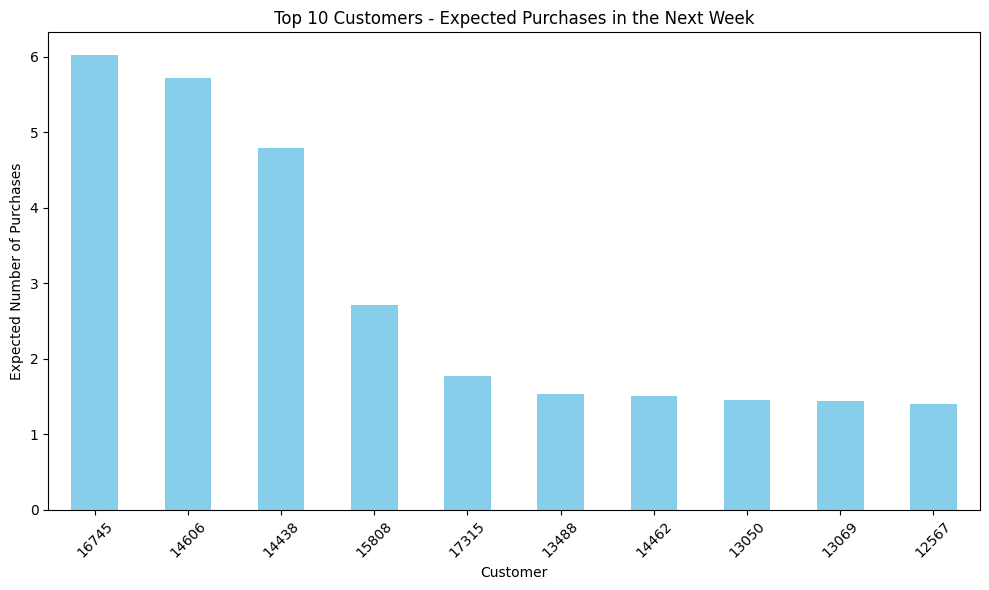

In [176]:
# find the top 10 customers who will purchase in the next 1 week
def top_customers(n):
    top_customers_n_week = bgf.conditional_expected_number_of_purchases_up_to_time(n,  # number of weeks
                                                            cltv_prediction["frequency"],
                                                            cltv_prediction["recency"],
                                                            cltv_prediction["T"]).sort_values(ascending=False).head(10)
    return top_customers_n_week

print(f"top 10 customers and their expected number of purchase in the following week: {top_customers(1)}")

plt.figure(figsize=(10, 6))
top_customers(1).plot(kind='bar', color='skyblue')
plt.title('Top 10 Customers - Expected Purchases in the Next Week')
plt.xlabel('Customer')
plt.ylabel('Expected Number of Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Expected number of transactions in the next month: [np.float64(101.49277003192867), np.float64(199.3659583506502), np.float64(294.7893610004062), np.float64(388.2118380981566)]


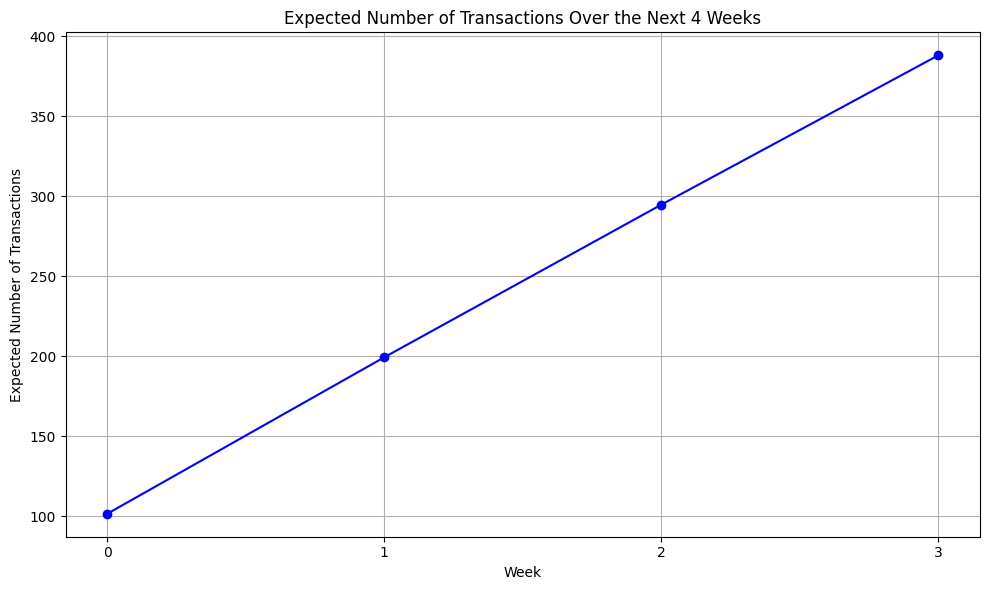

In [177]:
# number of transactions expected by the company in a month
def expected_num_transactions(num_weeks):
    res = []
    weeks = []
    for week in range(num_weeks):
        num_transactions_in_week = bgf.predict(week+1, cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"]).sum()
        res.append(num_transactions_in_week)
        weeks.append(week)
    return weeks, res

# get the expected number of transactions for the next 4 weeks
num_weeks = 4 # can be changed
weeks, expected_num_transactions_in_next_4_weeks = expected_num_transactions(num_weeks)
print(f"Expected number of transactions in the next month: {expected_num_transactions_in_next_4_weeks}")

plt.figure(figsize=(10, 6))
plt.plot(weeks, expected_num_transactions_in_next_4_weeks, marker='o', color='b', linestyle='-')
plt.title('Expected Number of Transactions Over the Next 4 Weeks')
plt.xlabel('Week')
plt.ylabel('Expected Number of Transactions')
plt.xticks(weeks)
plt.grid(True)
plt.tight_layout()
plt.show()

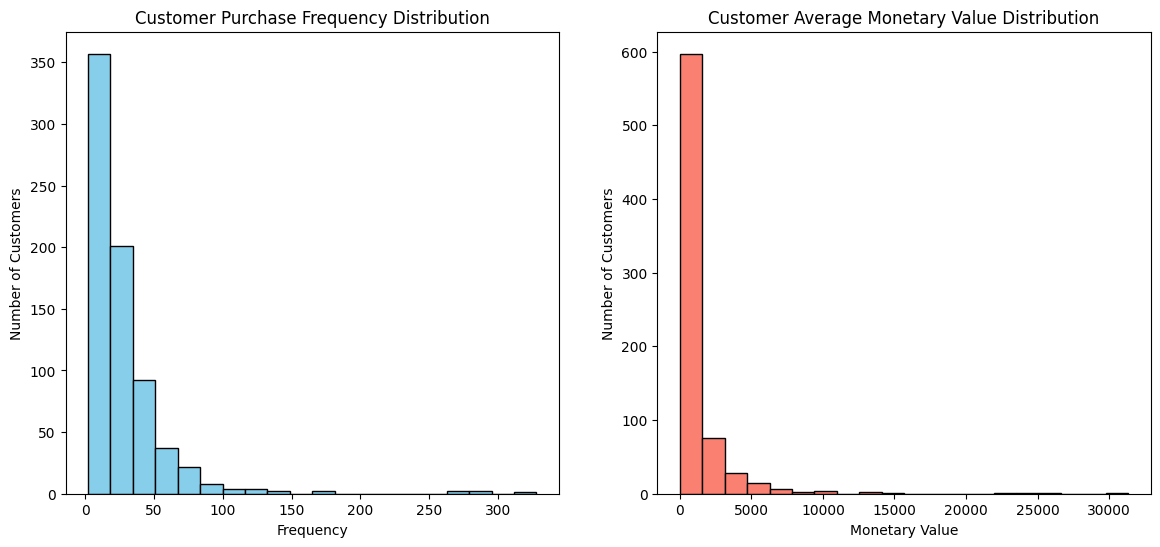

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(cltv_prediction['frequency'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title("Customer Purchase Frequency Distribution")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Number of Customers")

ax2.hist(cltv_prediction['monetary'], bins=20, color='salmon', edgecolor='black')
ax2.set_title("Customer Average Monetary Value Distribution")
ax2.set_xlabel("Monetary Value")
ax2.set_ylabel("Number of Customers")

plt.show()


### Gamma-Gamma Model

It is used to estimate how much profit a customer can generate on average per trade. The monetary value of a customer is randomly distributed around the average of the transaction values. The average transaction value may change between users over time, but not for a single user. The average transaction value is gamma distributed among all customers.

In [184]:
def gamma_gamma(df):
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(df["frequency"], df["monetary"])
    return ggf

ggf = gamma_gamma(cltv_prediction)

# Find average profit
cltv_prediction["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_prediction["frequency"], cltv_prediction["monetary"])

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_prediction["frequency"],
                                   cltv_prediction["recency"],
                                   cltv_prediction["T"],
                                   cltv_prediction["monetary"],
                                   time=3, # 3 months, how many months account do you want?
                                   freq="W", # frequency information of T
                                   discount_rate=0.01)
cltv = cltv.reset_index()

cltv_final = cltv_prediction.merge(cltv, on="user_id", how="left")
cltv_final.sort_values(by="clv", ascending=True).head(10)


,user_id,frequency,monetary,recency,T,expected_average_profit,clv
673,17850,177,994.922887,3.571429,52.142857,996.150248,6.790535e-200
567,17059,69,246.638174,0.142857,45.428571,247.456810,2.891115e-166
606,17337,139,1252.239532,0.142857,2.571429,1254.201049,1.490244e-163
609,17341,65,2801.427123,0.142857,39.142857,2810.763596,4.317690e-151
380,15464,68,2619.726971,0.142857,23.000000,2628.074682,2.459864e-142
469,16222,71,346.351268,0.142857,9.714286,347.449239,9.810843e-123
514,16686,51,161.997961,0.142857,26.000000,162.748896,1.478984e-109
293,14729,42,452.534167,0.142857,51.285714,454.939785,6.122298e-102
598,17284,49,950.341837,0.142857,21.428571,954.593264,3.766239e-100
208,14049,57,796.113228,0.142857,9.285714,799.182538,3.493442e-96


In [180]:
cltv_final["segment"]=pd.qcut(cltv_final["clv"],4,labels=["Low","Medium","High","Top"])

cltv_final.groupby("segment").agg({"count","mean","sum"})

user_id                 frequency                 monetary  \
                 mean count      sum       mean count   sum         mean   
segment                                                                    
Low      15430.255435   184  2839167  34.788043   184  6401  1191.217745   
Medium   15305.333333   183  2800876  23.781421   183  4352   818.933941   
High     15305.459016   183  2800899  20.426230   183  3738   907.627164   
Top      15301.771739   184  2815526  30.722826   184  5653  1929.118646   

                                recency  ...                       T        \
        count            sum       mean  ...          sum       mean count   
segment                                  ...                                 
Low       184  219184.065024   3.816770  ...   702.285714  30.302795   184   
Medium    183  149864.911118  14.288837  ...  2614.857143  34.086651   183   
High      183  166095.771023  22.894614  ...  4189.714286  37.013271   183   
Top       184  354957.830789  32.555124  ...  5990.142857  37.763975   184   

                     expected_average_profit                       \
                 sum                    mean count            sum   
segment                                                             
Low      5575.714286             1204.762043   184  221676.215887   
Medium   6237.857143              829.945912   183  151880.101898   
High     6773.428571              939.435598   183  171916.714466   
Top      6948.571429             1990.942417   184  366333.404715   

                  clv                      
                 mean count           sum  
segment                                    
Low      1.128292e-10   184  2.076058e-08  
Medium   1.421306e-01   183  2.600990e+01  
High     1.013898e+02   183  1.855433e+04  
Top      8.142885e+03   184  1.498291e+06  

[4 rows x 21 columns]

In [181]:
# Custom bin ranges
bins = [0, 100, 1000, 10000, float('inf')]
labels = ["Low", "Medium", "High", "Top"]

# Segment based on custom bins
cltv_final['clv_segment'] = pd.cut(cltv_final['clv'], bins=bins, labels=labels)
print(cltv_final[['user_id', 'clv', 'clv_segment']])

     user_id           clv clv_segment
0      12347  1.287056e+02      Medium
1      12348  4.047047e+03        High
2      12370  2.042844e-32         Low
3      12377  2.475600e+02      Medium
4      12383  5.939589e-10         Low
..       ...           ...         ...
729    18239  5.761900e+03        High
730    18245  2.061854e+02      Medium
731    18260  7.486555e-01         Low
732    18269  1.561572e+02      Medium
733    18283  2.259546e-12         Low

[734 rows x 3 columns]


clv_segment
Low       485
Medium    100
High      117
Top        32
Name: count, dtype: int64


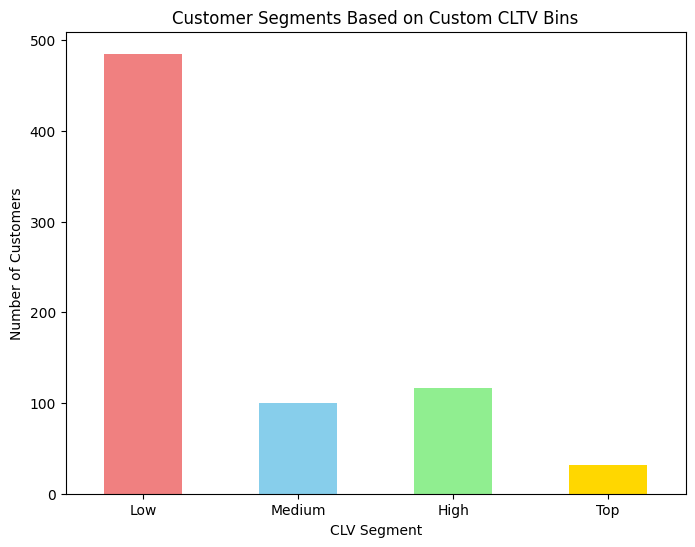

In [182]:
# Count the number of customers in each segment
segment_counts = cltv_final['clv_segment'].value_counts().reindex(labels)
print(segment_counts)
# Plot the segments
plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar', color=['lightcoral', 'skyblue', 'lightgreen', 'gold'])
plt.title("Customer Segments Based on Custom CLTV Bins")
plt.xlabel("CLV Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()

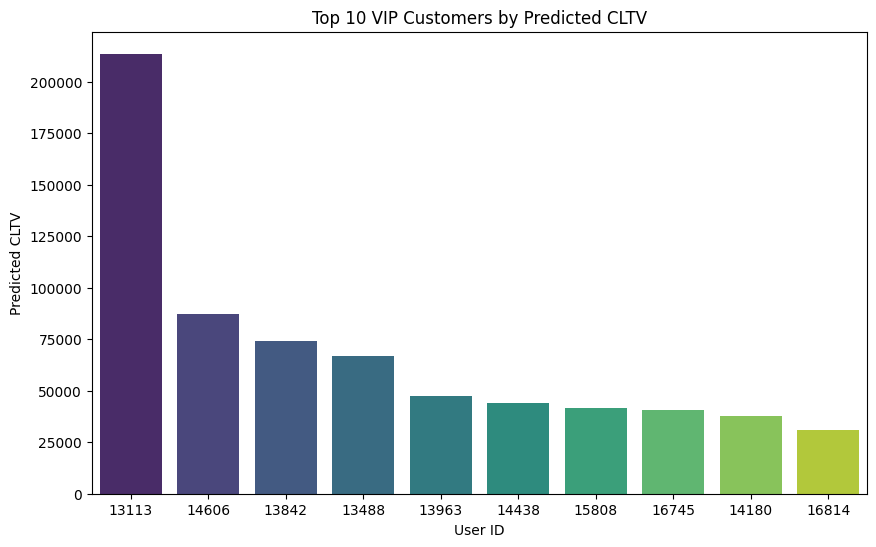

In [183]:
top_vip_customers = cltv_final[['user_id', 'clv']].sort_values(by='clv', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='clv', data=top_vip_customers, 
            palette='viridis', order=top_vip_customers.sort_values('clv', ascending=False)['user_id'])
plt.title('Top 10 VIP Customers by Predicted CLTV')
plt.xlabel('User ID')
plt.ylabel('Predicted CLTV')
plt.show()

# Evaluation against CLTV Calculation

Predictive CLTV models, like BG/NBD and Gamma-Gamma, are typically conservative and assume that not all customers will continue to purchase at the same frequency or value as they have historically hence, the predicted CLTV is often lower than the actual calculated CLTV.  

Predictive CLTV models usually assume a degree of customer churn and purchase decay, meaning that over time, some customers will stop purchasing, and the frequency or value of purchases may decrease.  

For instance, the BG/NBD model incorporates probabilities of "dropout" for each customer, inherently leading to more conservative CLTV predictions.  

Additionally, with limited historical data or low-frequency customers, predictive models have less data to accurately estimate long-term behavior, often resulting in conservative (lower) predictions.  

Models prioritize repeat purchasing behavior, which often reduces predicted CLTV for customers with sporadic or low-frequency purchases.